# Retirement Planner - Early Retirement!

---

## Environment Setup

In [2]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi

%matplotlib inline

In [3]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `90/10` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [4]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [6]:
# Display sample data
df.head()

AGG     SPY
                             close   close
2019-01-02 00:00:00-05:00  106.585  249.89
2019-01-03 00:00:00-05:00  107.020  244.46
2019-01-04 00:00:00-05:00  106.695  252.41
2019-01-07 00:00:00-05:00  106.470  254.40
2019-01-08 00:00:00-05:00  106.420  256.65

---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `500` iterations and generate at least `5` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 5 years`.

In [7]:
# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date
df.head()

AGG     SPY
              close   close
2019-01-02  106.585  249.89
2019-01-03  107.020  244.46
2019-01-04  106.695  252.41
2019-01-07  106.470  254.40
2019-01-08  106.420  256.65

In [8]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()

# Display sample data
daily_returns.head()

AGG       SPY
               close     close
2019-01-02       NaN       NaN
2019-01-03  0.004081 -0.021730
2019-01-04 -0.003037  0.032521
2019-01-07 -0.002109  0.007884
2019-01-08 -0.000470  0.008844

In [9]:
# Use the `mean` function to calculate the mean of daily returns for `AGG` and `SPY`, respectively
avg_daily_return_AGG = daily_returns.mean()["AGG"]["close"]
avg_daily_return_SPY = daily_returns.mean()["SPY"]["close"]

In [10]:
# Compute daily volatility - calculate std()
std_daily_return_AGG = daily_returns.std()["AGG"]["close"]
std_daily_return_SPY = daily_returns.std()["SPY"]["close"]

In [11]:
# Save the last day's closing price
# Set last closing prices of `AGG` and `SPY`
AGG_last_price = df["AGG"]["close"][-1]
SPY_last_price = df["SPY"]["close"][-1]

In [62]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 5

#Set portfolio weights
weights = [0.1, 0.9]

# Create empty DataFrames to hold simulation results
monte_carlo = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [85]:
# Run the Monte Carlo Simulation
for n in range(number_simulations):
    
    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    simulated_AGG_prices = [AGG_last_price]
    simulated_SPY_prices = [SPY_last_price]
    
    # Simulate the returns for 252 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_AGG_price = simulated_AGG_prices[-1] * (1 + np.random.normal(avg_daily_return_AGG, std_daily_return_AGG))
        simulated_SPY_price = simulated_SPY_prices[-1] * (1 + np.random.normal(avg_daily_return_SPY, std_daily_return_SPY))
        
        # Append the simulated price to the list
        simulated_AGG_prices.append(simulated_AGG_price)
        simulated_SPY_prices.append(simulated_SPY_price)
    
    # Append a simulated prices of each simulation to DataFrame
    monte_carlo["AGG prices"] = pd.Series(simulated_AGG_prices)
    monte_carlo["SPY prices"] = pd.Series(simulated_SPY_prices)
 
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = monte_carlo.pct_change()
    
    # Use the `dot` function with the weights to multiply weights with each column"s simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
# Check that the simulation ran successfully
portfolio_cumulative_returns.head()

0         1         2         3         4         5         6    \
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  0.987806  0.997371  1.010781  0.983713  0.998390  1.007923  0.998812   
2  0.995453  0.995159  1.005573  0.981820  0.999814  1.010249  0.991613   
3  0.985235  1.006483  1.010112  0.972999  0.998568  1.007324  0.986679   
4  1.001139  1.005991  1.003696  0.973831  0.986509  1.008274  0.979478   

        7         8         9    ...       490       491       492       493  \
0  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000   
1  1.007939  0.995404  1.003231  ...  0.998806  0.994275  0.998065  1.005929   
2  1.011777  0.996848  1.002894  ...  0.996739  1.000348  1.001535  1.012393   
3  1.007790  1.011074  1.003345  ...  0.999287  1.003770  1.010849  1.011506   
4  0.989569  1.021882  0.991127  ...  0.993472  1.006278  1.007508  1.012746   

        494       495       496       497       498       499  
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1  1.005219  1.003473  0.999825  0.988721  1.010392  0.992671  
2  1.002383  1.016628  1.010409  1.000083  1.015231  1.000789  
3  0.995185  1.010935  1.000888  0.983593  1.018360  0.992564  
4  0.998205  1.011025  1.002861  0.985912  1.021219  1.000286  

[5 rows x 500 columns]

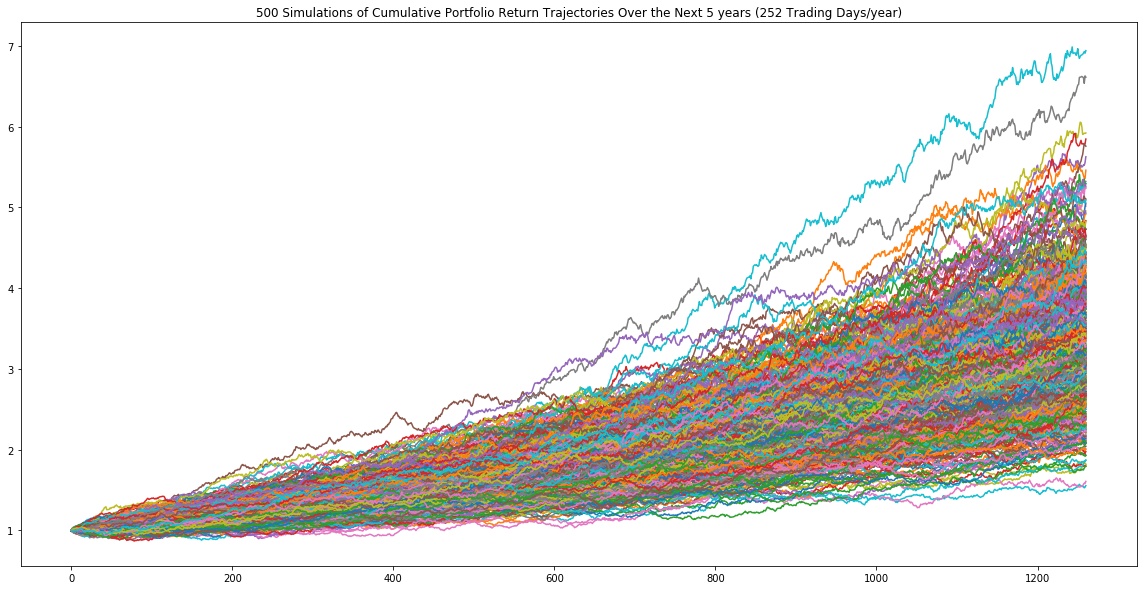

In [86]:
# Visualize the Simulation
# Use the `plot` function to plot `500` simulations of the potential trajectories of the portfolio based on 252 trading days for 5 years
plot_title = "500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 5 years (252 Trading Days/year)"
portfolio_cumulative_returns.plot(figsize=(20,10),legend=None, title=plot_title)

In [87]:
# Select the last row for the cumulative returns (cumulative returns at 5 years)
last_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
last_cumulative_returns.to_frame().tail(1)

1260
499  4.327806

In [88]:
# Display the 90% confidence interval for the ending returns
confidence_interval = last_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    2.160922
0.95    4.653944
Name: 1260, dtype: float64

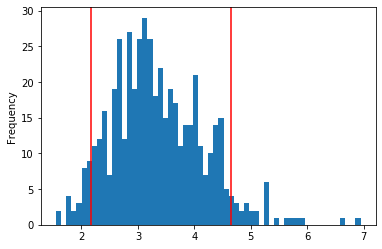

In [89]:
# Visualize the distribution of the ending returns
# Import standalone matplotlib library
import matplotlib.pyplot as plt

# Set boundaries for lower and upper bound of `90%` confidence interval
# Set boundary lines to red
plt.figure()
last_cumulative_returns.plot(kind = 'hist', bins = 60)
plt.axvline(confidence_interval.iloc[0], color="r")
plt.axvline(confidence_interval.iloc[1], color="r")

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `5` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$80,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 5 years for the 10th, 50th, and 90th percentiles?

In [90]:
# Compute cumulative returns
cumulative_returns_5_years = last_cumulative_returns.quantile(q = [0.1, 0.5, 0.9]).round(2)
cumulative_returns_5_years

0.1    2.34
0.5    3.22
0.9    4.41
Name: 1260, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [91]:
# Set initial investment
initial_investment = 80000
# Compute expected portfolio return
expected_portfolio_returns = (cumulative_returns_5_years * initial_investment).round(2)

# Print expected portfolio return at the 10th, 50th and 90th percentiles
expected_portfolio_returns

0.1    187200.0
0.5    257600.0
0.9    352800.0
Name: 1260, dtype: float64

### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [92]:
# Set Plaid's projected income
projected_yearly_income = 7389

# Print Projected yearly income
print (f"Projected yearly income : ${projected_yearly_income}")

# Calculate the 4% withdrawal for the ending return as retirement income
pct_return_4_percent = expected_portfolio_returns[0.1] * 0.04

# Print 4% withdrawal for the ending return as retirement income
print (f"4% withdrawal for the ending return as retirement income : ${pct_return_4_percent:.0f}")

# Determine if the retirement income meets or exceeds the current projected income
if projected_yearly_income < pct_return_4_percent:
    print ("The retirement income exceeds the current projected income")
elif projected_yearly_income == pct_return_4_percent:
    print ("The retirement income meets the current projected income")
else:
    print ("The retirement income does not meet or exceed the current projected income")

Projected yearly income : $7389
4% withdrawal for the ending return as retirement income : $7488
The retirement income exceeds the current projected income


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [93]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
new_initial_investment = initial_investment * 1.5

# Compute expected portfolio return
new_expected_portfolio_returns = (cumulative_returns_5_years * new_initial_investment).round(2)

# Compute 4% withdraw rate from the retirement portfolio at the 10th percentile after 50% increase
new_pct_return_4_percent = new_expected_portfolio_returns[0.1] * 0.04

# Print 4% withdraw rate from the retirement portfolio with 50% increase in the initial investment
print (f"4% withdraw rate from the retirement portfolio with 50% increase in the initial investment : ${new_pct_return_4_percent:.0f}")

4% withdraw rate from the retirement portfolio with 50% increase in the initial investment : $11232


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal? In other words, what happens if the initial investment had been bigger?

- 50% increase in the initial investment amount affects the 4% retirement withdrawal by $3,744

### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [72]:
# Compute projected returns at the 5%, 50%, and 95%
projected_returns = portfolio_cumulative_returns.quantile(q = [0.05, 0.5, 0.95], axis=1).round(2)

# Display sample data
projected_returns = projected_returns.T
projected_returns

0.05  0.50  0.95
0     1.00  1.00  1.00
1     0.99  1.00  1.01
2     0.99  1.00  1.02
3     0.98  1.00  1.02
4     0.98  1.00  1.03
...    ...   ...   ...
1256  2.16  3.28  4.91
1257  2.18  3.28  4.91
1258  2.18  3.28  4.91
1259  2.19  3.29  4.90
1260  2.18  3.29  4.92

[1261 rows x 3 columns]

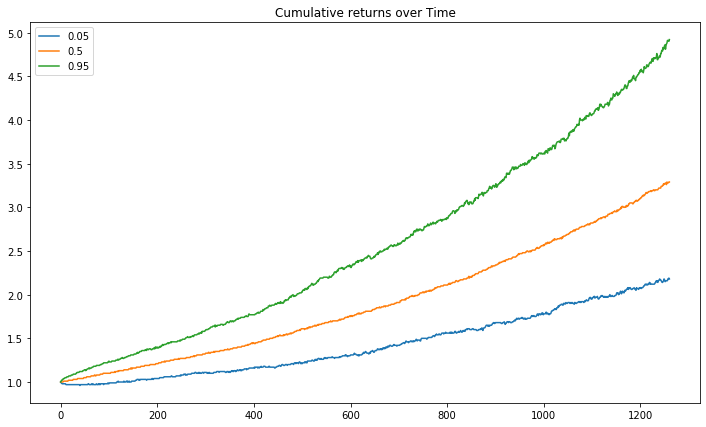

In [73]:
# Plot the cumulative returns over time
projected_returns.plot(figsize = (12,7), title = "Cumulative returns over Time")

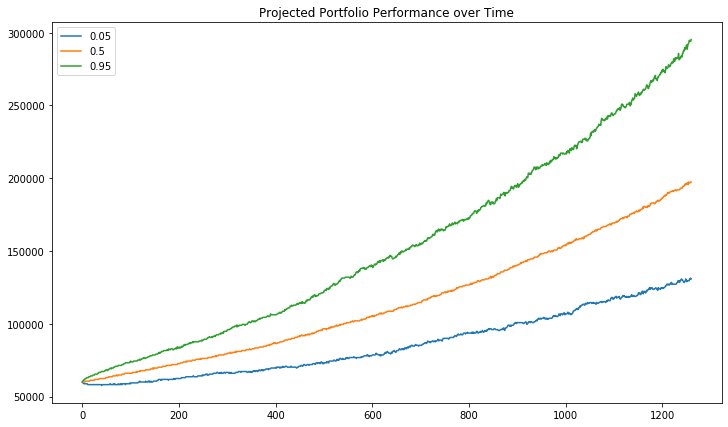

In [74]:
# Compute portfolio performance over time
portfolio_performance = initial_investment * projected_returns
# Plot projected performance over time
portfolio_performance.plot(title="Projected Portfolio Performance over Time", figsize = (12,7))